In [14]:
import sys 
sys.path.append("..")
import cv2 
from get_rostopic import RealsenseD435i
import numpy as np 
import rospy 
import matplotlib.pyplot as plt 
from utils.utils_pcl import *
from utils.utils_pointcloud import * 
print("Done.")


Done.


In [15]:
rospy.init_node('Realsense')
mode     = "pointcloud"
camera   = RealsenseD435i(mode=mode)
name = "1025_test1"
if mode=="depth":
    save_depth_img(msg_depth = camera.depth_image, name = name) 
else: 
    save_pc(msg_pc=camera.point_cloud, name=name)


Max Depth: 2.509000062942505
Min Depth: -1.1081786155700684
Average Depth: 0.7058316424576775
SAVED IMAGE


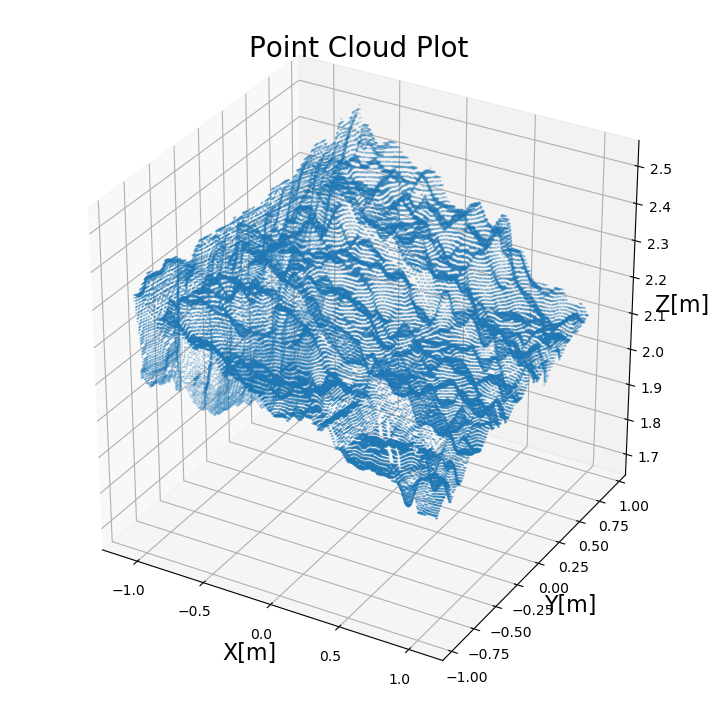

In [18]:
np_data = np.load("./data/npy/1025_test1.npy")
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
ax.scatter([point[0] for point in np_data], [point[1] for point in np_data], [point[2] for point in np_data], s=0.05)
ax.set_xlabel("X[m]", fontsize=16)
ax.set_ylabel("Y[m]",fontsize=16)
ax.set_zlabel("Z[m]", fontsize=16)

plt.title("Point Cloud Plot", fontsize=20)
plt.show()

In [30]:
def do_ransac_plane_normal_segmentation(point_cloud, input_max_distance):
    segmenter = point_cloud.make_segmenter_normals(ksearch=50)
    segmenter.set_optimize_coefficients(True)
    segmenter.set_model_type(pcl.SACMODEL_NORMAL_PLANE)  #pcl_sac_model_plane
    segmenter.set_normal_distance_weight(0.1)
    segmenter.set_method_type(pcl.SAC_RANSAC) #pcl_sac_ransac
    segmenter.set_max_iterations(100)
    segmenter.set_distance_threshold(input_max_distance) #0.03)  #max_distance
    indices, coefficients = segmenter.segment()

    print('Model coefficients: ' + str(coefficients[0]) + ' ' + str(
        coefficients[1]) + ' ' + str(coefficients[2]) + ' ' + str(coefficients[3]))

    print('Model inliers: ' + str(len(indices)))
    for i in range(0, 5):#range(0, len(indices)):
        print(str(indices[i]) + ', x: ' + str(point_cloud[indices[i]][0]) + ', y : ' +
              str(point_cloud[indices[i]][1]) + ', z : ' + str(point_cloud[indices[i]][2]))

    inliers = point_cloud.extract(indices, negative=False)
    outliers = point_cloud.extract(indices, negative=True)

    return indices, inliers, outliers

In [31]:
point = ros_to_pcl(camera.point_cloud)
print(point)
cloud_voxel = do_voxel_grid_downssampling(point, 0.01)
cloud_pass_z = do_passthrough(cloud_voxel, 'x', axis_min=0.01, axis_max=1.5)

outliner_object = do_ransac_plane_segmentation(cloud_pass_z,pcl.SACMODEL_PLANE,pcl.SAC_RANSAC,0.01)
outliner_object = outliner_object.to_array()
print(outliner_object.shape)

<PointCloud of 115570 points>
(17633, 4)


In [32]:
indices, inliers, outliers = do_ransac_plane_normal_segmentation(cloud_pass_z, 0.01)

Model coefficients: 0.2075263410806656 -0.13688935339450836 0.9686041474342346 -2.1621975898742676
Model inliers: 144
930, x: 0.7179682850837708, y : -0.7458740472793579, z : 1.9660000801086426
1297, x: 0.7149078845977783, y : -0.7507762312889099, z : 1.9720001220703125
3239, x: 0.5537383556365967, y : -0.6040774583816528, z : 2.0260000228881836
5127, x: 0.2650722563266754, y : -0.7460207939147949, z : 2.068000078201294
5778, x: 0.7660112977027893, y : -0.10676458477973938, z : 2.06000018119812


shutdown request: [/Realsense] Reason: new node registered with same name
